In [47]:
import pandas as pd
import numpy as np
import json
import os
import operator
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import evaluate_queries as evaluate_queries

import utils

from pathlib import Path

from sklearn.metrics import ndcg_score
from tqdm import tqdm

sns.set(rc={'figure.figsize':(24, 14)}, font_scale=2)

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Functions

In [49]:
def update_df(df, scores_path):
    '''
    Given a wikipages queries dataframe `df` and its respective NDCG `scores_path`
    update df to map the NDCG scores @k for each wikipage
    '''
    for file in os.listdir(scores_path):
        with open(scores_path + file, 'r') as f:
            scores_dict = json.load(f)

        wikipage_id_to_score = {}
        for wikipage_id in scores_dict:
            wikipage_id_to_score[int(wikipage_id)] = scores_dict[wikipage_id]['ndcg']
        
        k = file.split('_')[-1].split('.')[0]
        df['ndcg@'+k] = np.nan
        df['ndcg@'+k] = df['wikipage_id'].map(wikipage_id_to_score)

    return df

def get_query_df_dict(query_df_base_dir, score_paths_base_dir, min_tuple_width, mode, tuples_per_query_list):
    # Dictionary keyed by the number of tuples per query to the query dataframe that contains the NDCG scores at various k values
    query_df_dict = {}

    for tuples_per_query in tuples_per_query_list:
        df = pd.read_pickle(query_df_base_dir+'minTupleWidth_2_tuplesPerQuery_'+str(tuples_per_query)+'.pickle')  
        scores_path = score_paths_base_dir + 'minTupleWidth_' + str(min_tuple_width) + '_tuplesPerQuery_' + str(tuples_per_query) + '/' + mode + '/'

        query_df_dict[tuples_per_query] = update_df(df, scores_path)
    
    return query_df_dict

def get_ndcg_scores_at_k_stats(df_dict, top_k_vals, tuples_per_query_list):
    '''
    Returns the dictionaries indexed by the tuples_per_query corresponding to the mean and standard deviation of the ndcg@k scores
    '''
    mean_ndcg_scores_at_k = {}
    std_ndcg_scores_at_k = {}
    for tuples_per_query in tuples_per_query_list:
        mean_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].mean() for k in top_k_vals]
        std_ndcg_scores_at_k[tuples_per_query] = [df_dict[tuples_per_query]['ndcg@'+str(k)].std() for k in top_k_vals]
    return mean_ndcg_scores_at_k, std_ndcg_scores_at_k

In [50]:
def get_relevant_wikipages(wikipage_id, relevance_scores_dir):
    with open(relevance_scores_dir + str(wikipage_id) + '.json') as fp:
        relevant_wikipages = json.load(fp)
    print(relevant_wikipages)

def get_wikipage_attributes(wikipage_id, wikipage_to_attributes_dict, df):
    # Convert the wikipage_id into a wikipage name
    wikipage = df[df['wikipage_id'] == wikipage_id]['wikipage'].values[0]
    wikipage = wikipage.split('/')[-1]
    print(wikipage_to_attributes_dict[wikipage])

def get_query(wikipage_id, queries_path, k=None):
    with open(queries_path + 'wikipage_' + str(wikipage_id) + '.json') as fp:
        query_dict = json.load(fp)
    for tuple in query_dict['queries']:
        print(tuple)

def get_top_k_results(wikipage_id, scores_dir, k=10):
    with open(scores_dir + 'wikipage_' + str(wikipage_id)+'/search_output/filenameToScore.json') as fp:
        scores_dicts = json.load(fp)['scores']
    top_k_wikipages = []
    for dict in scores_dicts[:k]:
        top_k_wikipages.append(dict['pgTitle'])
    return top_k_wikipages

def get_top_k_bm25(wikipage_id, bm_25_scores_dir, table_to_wikipage_id_dict, df, k=10):
    scores_df = pd.read_csv(bm_25_scores_dir, sep="\t", index_col=False, names=["wikipage_id", "query", "table_id", "rank", "score", "field"])
    scores_df = scores_df[scores_df['wikipage_id'] == wikipage_id].sort_values(by='rank')
    top_k_wikipages = []
    for idx, row in scores_df.head(k).iterrows():
        wikipage_id = table_to_wikipage_id_dict[row['table_id']]
        wikipage = df[df['wikipage_id']==wikipage_id]['wikipage'].values[0].split('/')[-1]
        top_k_wikipages.append(wikipage)
    return top_k_wikipages   

def get_query_summary(wikipage_id, df, relevance_scores_dir, queries_path, wikipage_to_attributes_dict, scores_dir, bm_25_scores_dir, table_to_wikipage_id_dict, k=10):
    print("Query Constructed from Wikipedia Page:", df[df['wikipage_id'] == wikipage_id]['wikipage'].values[0])

    print("\nQuery Tuples:")
    get_query(wikipage_id, queries_path)

    print('\nWikipedia Categories of query Wikipage:')
    get_wikipage_attributes(wikipage_id, wikipage_to_attributes_dict, df)

    print('\nRelevant Wikipages (Ground Truth):')
    get_relevant_wikipages(wikipage_id, relevance_scores_dir)

    print("\nTop-" + str(k), "tables found using Adj. Jaccard (Unweighted + Avg. Similarity per Column):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'unweighted/avg_similarity_per_col/', k=k))

    print("\nTop-" + str(k), "tables found using Adj. Jaccard (Unweighted + Max Similarity per Column):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'unweighted/max_similarity_per_col/', k=k))

    print("\nTop-" + str(k), "tables found using Adj. Jaccard (Weighted + Avg. Similarity per Column):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'weighted/avg_similarity_per_col/', k=k))

    print("\nTop-" + str(k), "tables found using Adj. Jaccard (Weighted + Max Similarity per Column):")
    print(get_top_k_results(wikipage_id=wikipage_id, scores_dir=scores_dir+'weighted/max_similarity_per_col/', k=k))

    print("\nTop-" + str(k), "tables found using BM25 (Entity Queries):")
    print(get_top_k_bm25(wikipage_id=wikipage_id, bm_25_scores_dir=bm_25_scores_dir+'entities/content.txt', 
        table_to_wikipage_id_dict=table_to_wikipage_id_dict, df=df, k=k))

    print("\nTop-" + str(k), "tables found using BM25 (Text Queries):")
    print(get_top_k_bm25(wikipage_id=wikipage_id, bm_25_scores_dir=bm_25_scores_dir+'text/content.txt', 
        table_to_wikipage_id_dict=table_to_wikipage_id_dict, df=df, k=k))

# Adjusted Jaccard of DBpedia Types

In [51]:
query_df_base_dir = '../../data/queries/wikipages/query_dataframes/wikipages_test_dataset/filtered_queries/'
min_tuple_width=2
tuples_per_query_list = [1, 2, 5, 10]
top_k_vals = [1,5,10,15,20,30]

In [52]:
adj_jaccard_unweighted_avg_sim_per_col_scores='eval_over_search_output/wikipages_test_dataset/filtered_queries/adjusted_jaccard/unweighted/avg_similarity_per_col/'
adj_jaccard_unweighted_max_sim_per_col_scores='eval_over_search_output/wikipages_test_dataset/filtered_queries/adjusted_jaccard/unweighted/max_similarity_per_col/'
adj_jaccard_weighted_avg_sim_per_col_scores='eval_over_search_output/wikipages_test_dataset/filtered_queries/adjusted_jaccard/weighted/avg_similarity_per_col/'
adj_jaccard_weighted_max_sim_per_col_scores='eval_over_search_output/wikipages_test_dataset/filtered_queries/adjusted_jaccard/weighted/max_similarity_per_col/'

# Get the dataframes of the evaluation scores at different # of tuples per query 
adj_jaccard_unweighted_avg_sim_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_unweighted_avg_sim_per_col_scores,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

adj_jaccard_unweighted_max_sim_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_unweighted_max_sim_per_col_scores,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

adj_jaccard_weighted_avg_sim_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_weighted_avg_sim_per_col_scores,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

adj_jaccard_weighted_max_sim_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_weighted_max_sim_per_col_scores,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
adj_jaccard_mean_ndcg_scores_at_k_unweighted_avg_sim, _ = get_ndcg_scores_at_k_stats(adj_jaccard_unweighted_avg_sim_df, top_k_vals, tuples_per_query_list)
adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim, _ = get_ndcg_scores_at_k_stats(adj_jaccard_unweighted_max_sim_df, top_k_vals, tuples_per_query_list)
adj_jaccard_mean_ndcg_scores_at_k_weighted_avg_sim, _ = get_ndcg_scores_at_k_stats(adj_jaccard_weighted_avg_sim_df, top_k_vals, tuples_per_query_list)
adj_jaccard_mean_ndcg_scores_at_k_weighted_max_sim, _ = get_ndcg_scores_at_k_stats(adj_jaccard_weighted_max_sim_df, top_k_vals, tuples_per_query_list)

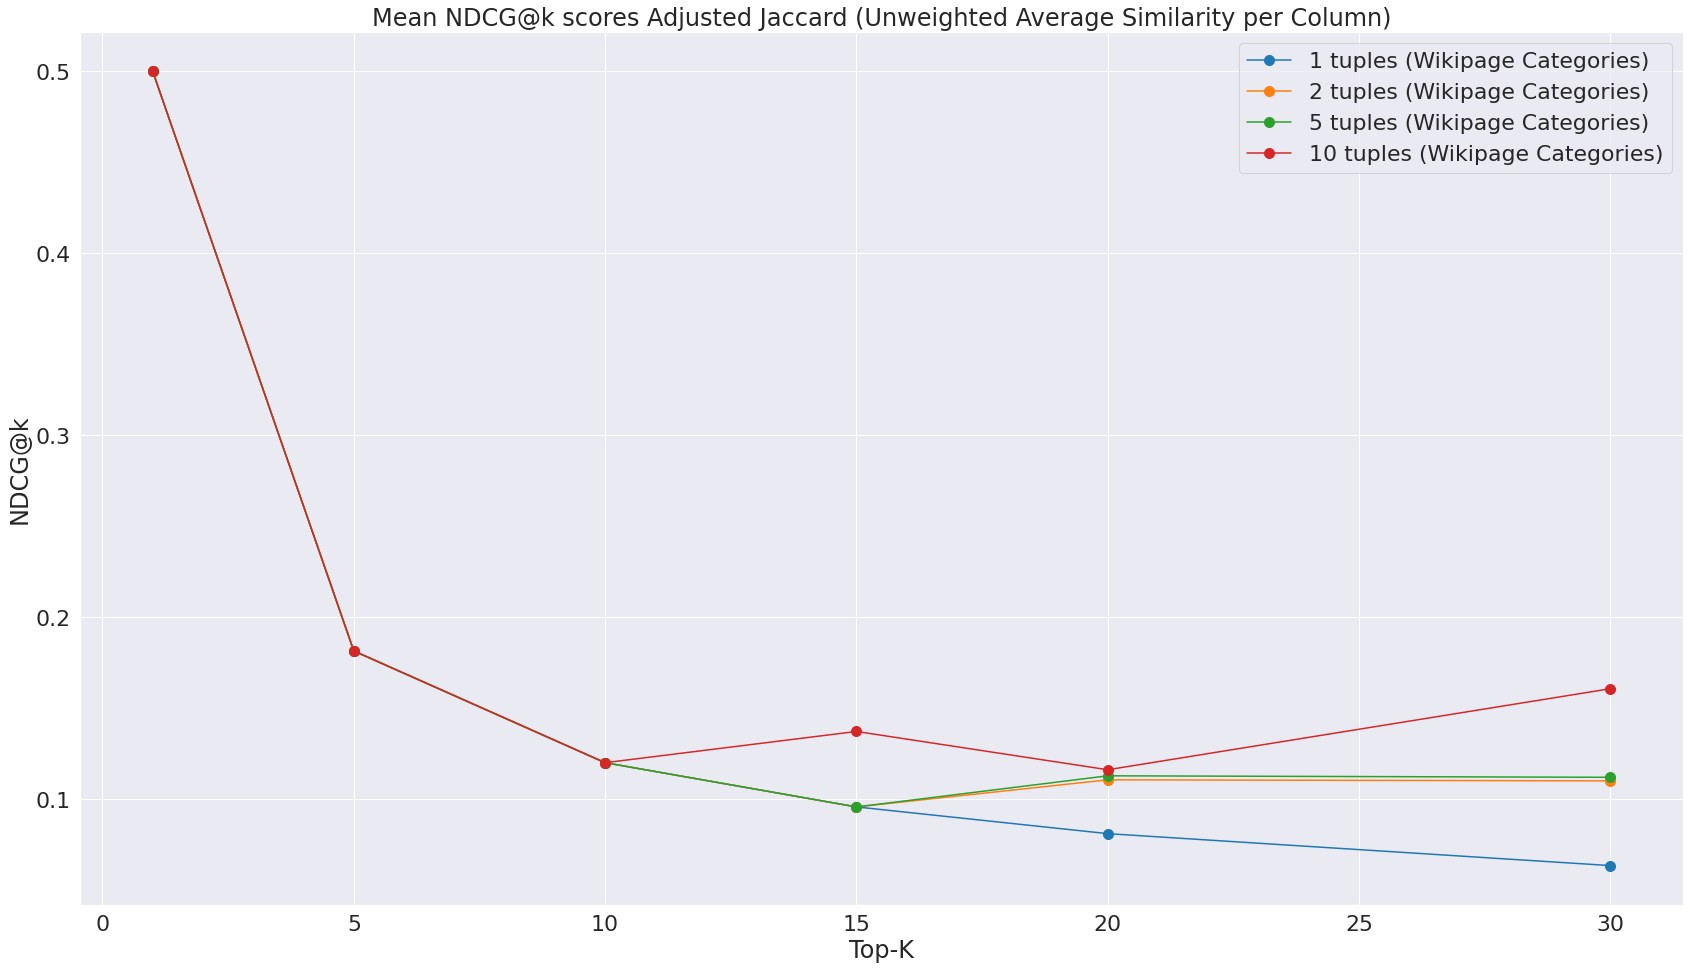

In [24]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_avg_sim[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

plt.legend();ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard (Unweighted Average Similarity per Column)');plt.tight_layout()

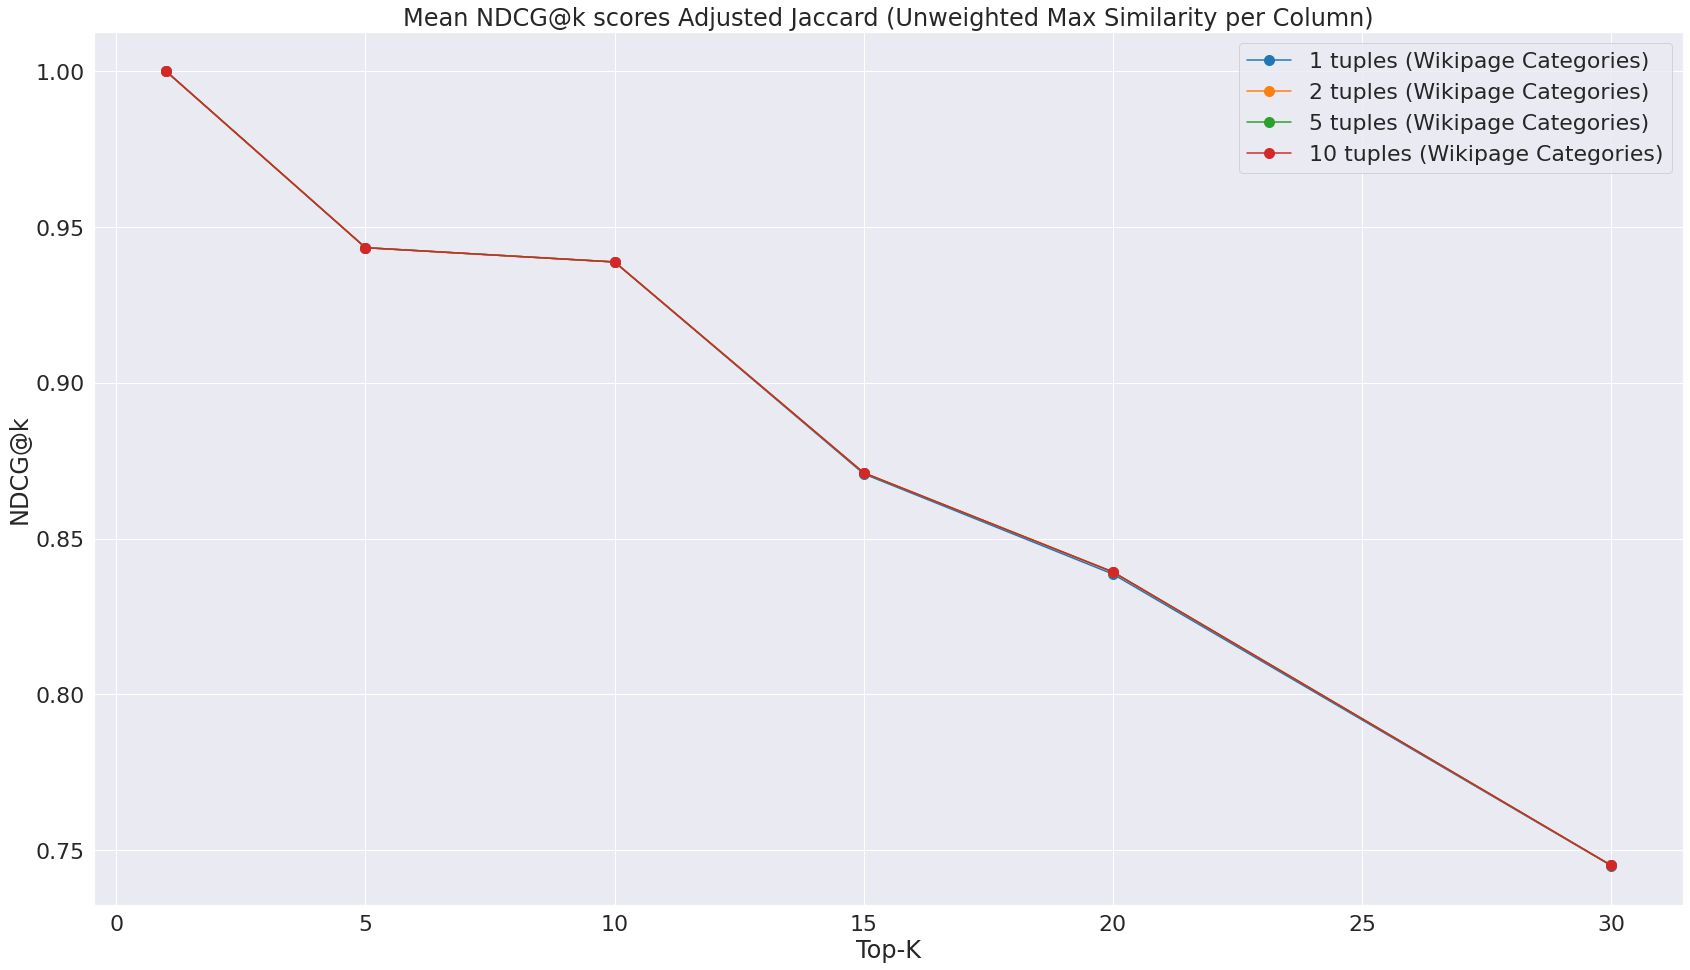

In [25]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

plt.legend();ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard (Unweighted Max Similarity per Column)');plt.tight_layout()

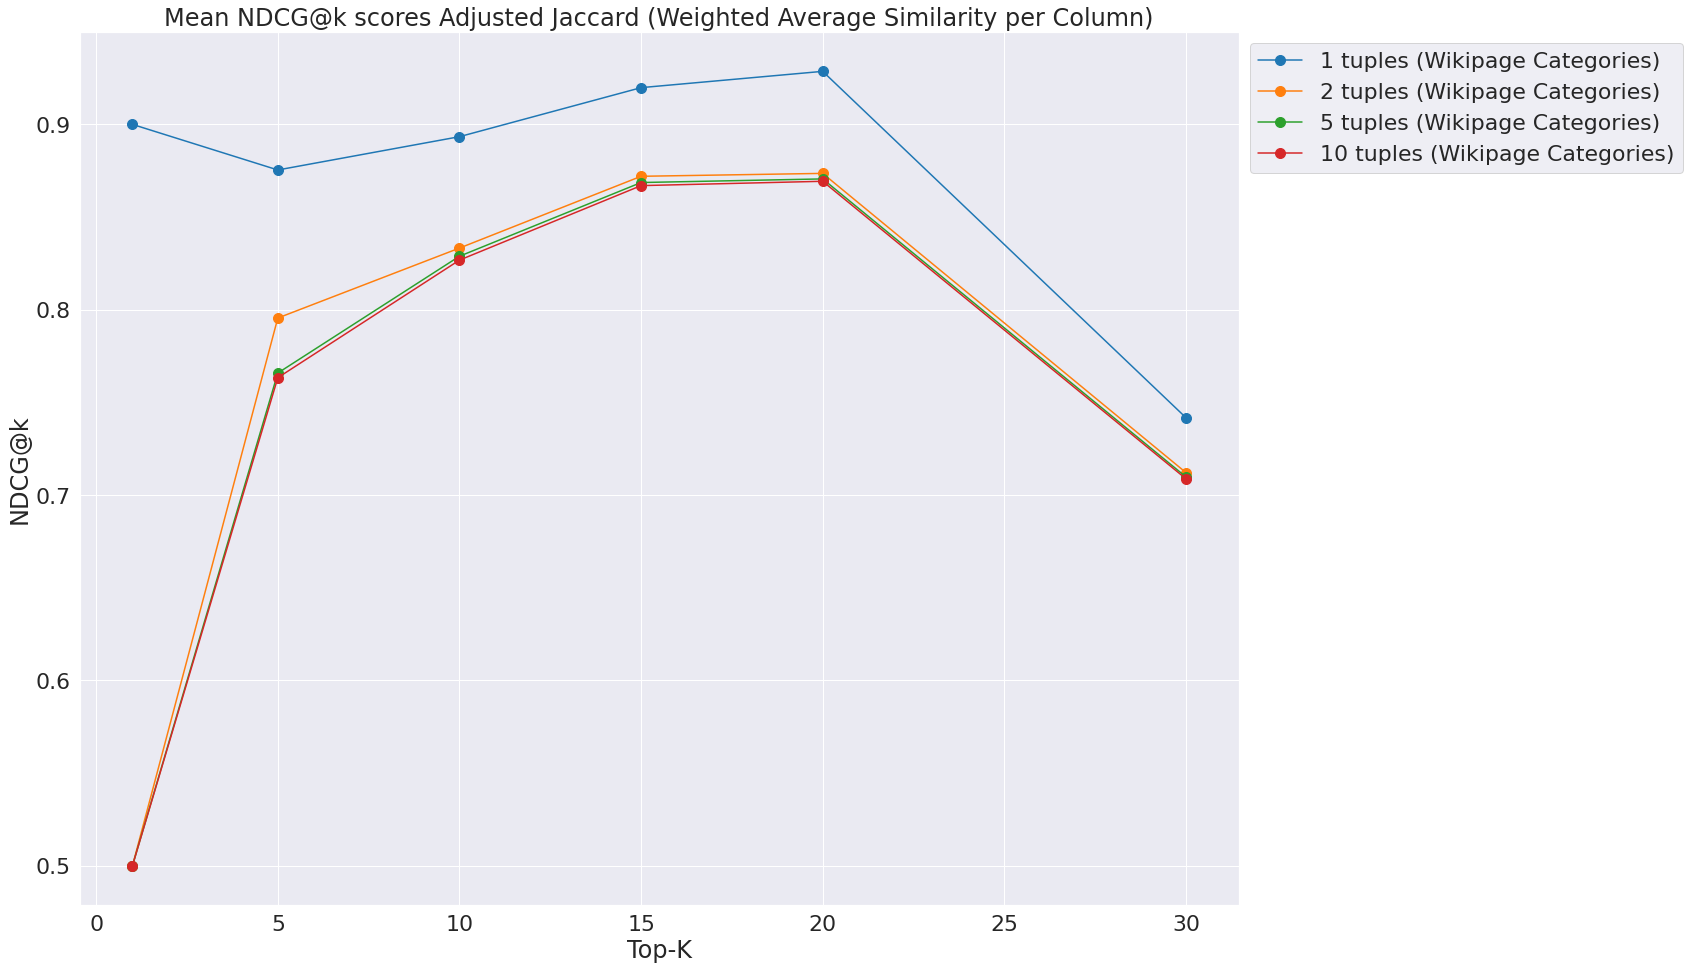

In [26]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_avg_sim[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

plt.legend();ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard (Weighted Average Similarity per Column)');plt.tight_layout()

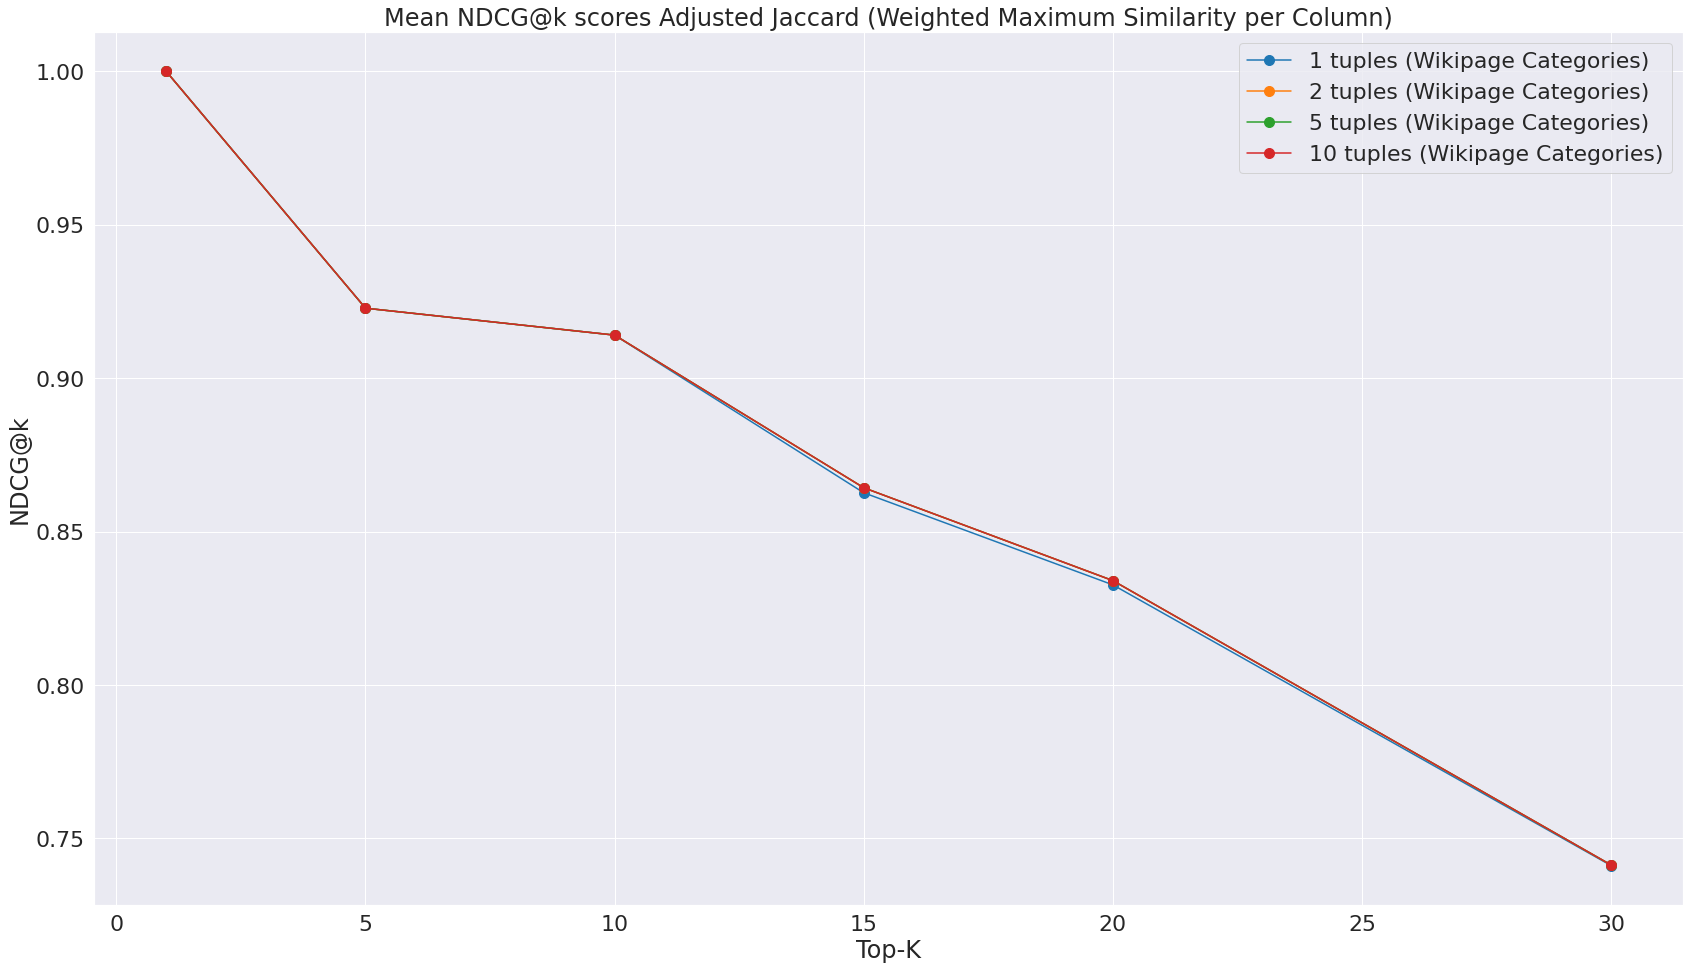

In [27]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_max_sim[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Wikipage Categories)')

plt.legend();ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard (Weighted Maximum Similarity per Column)');plt.tight_layout()

# BM25 Evaluation

In [28]:
tuples_per_query_list = [1, 2, 5, 10]
top_k_vals = [1,5,10,15,20,30]

In [29]:
with open('evaluation_dataframes/wikipages_testing_filtered_queries_bm25_dfs_dict.pickle', 'rb') as handle:
    dfs_dict = pickle.load(handle)

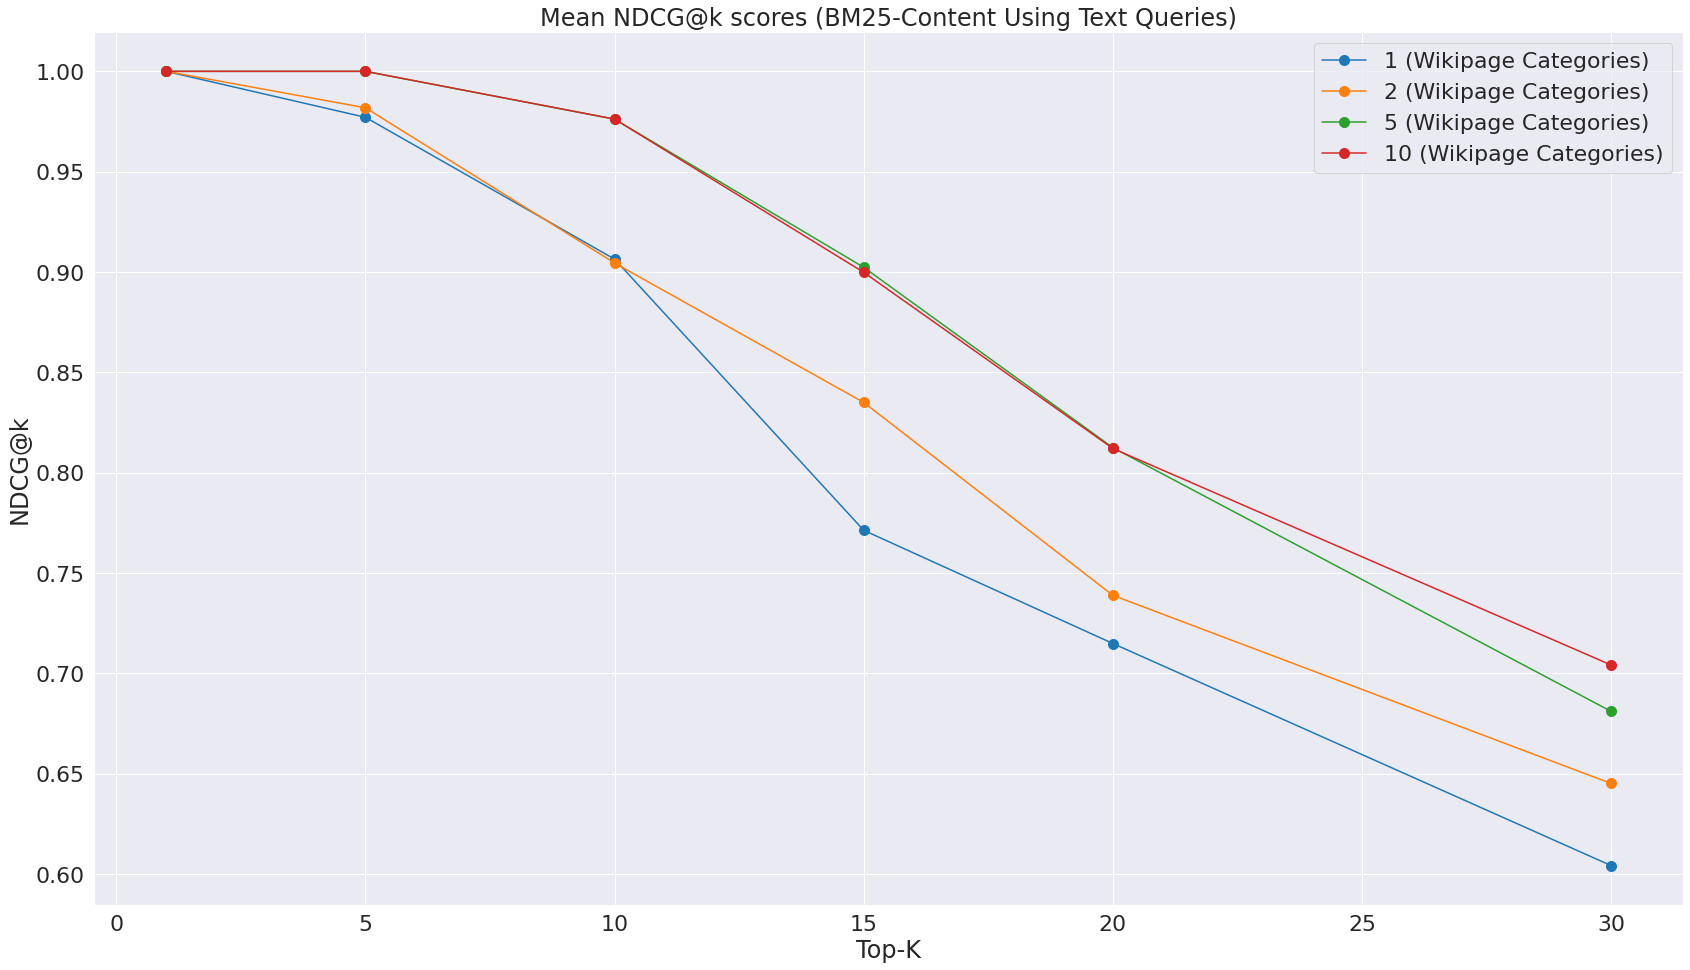

In [30]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Text Queries)');plt.tight_layout()
# plt.savefig('figures/filtered_queries/expanded_wikipages_dataset_topk_ndcg@k_bm25_text_queries_categories_vs_navigation_links.svg')

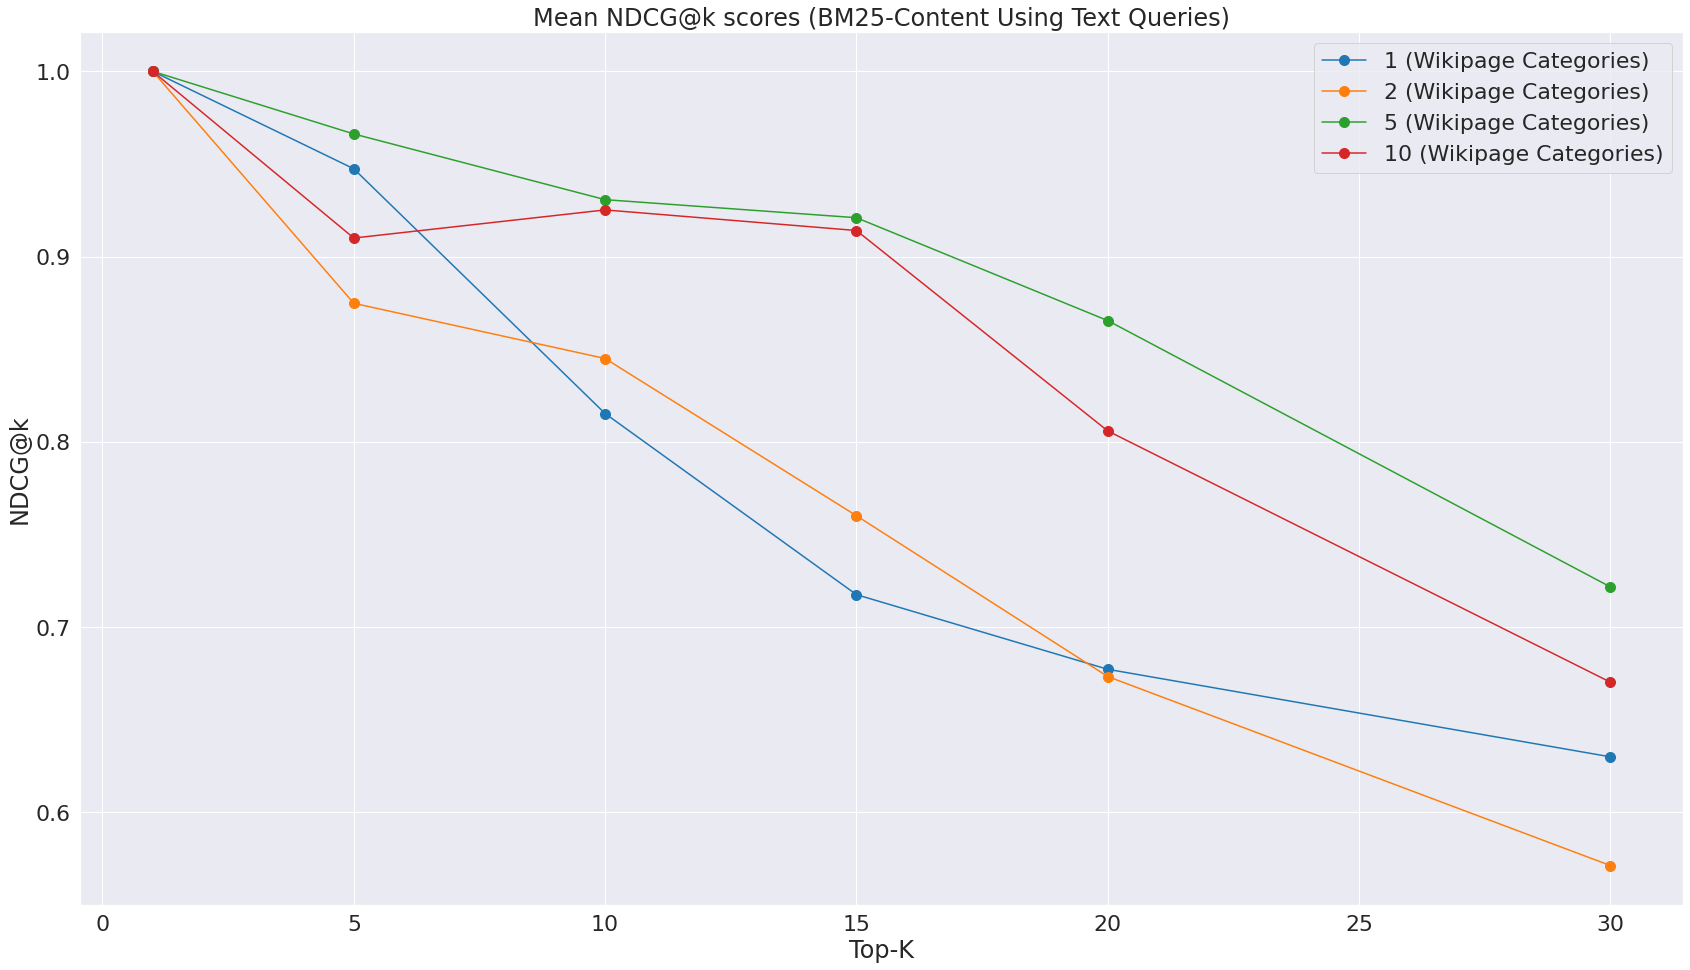

In [31]:
colors = ['tab:blue', 'tab:orange','tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    mean_ndcg_scores_at_k_categories = [dfs_dict[tuples_per_query_list[i]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

    plt.plot(top_k_vals, mean_ndcg_scores_at_k_categories, marker='o', markersize=10, label=str(tuples_per_query_list[i]) + ' (Wikipage Categories)', color=colors[i])

ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (BM25-Content Using Text Queries)');plt.tight_layout()

# Comparison across different methods

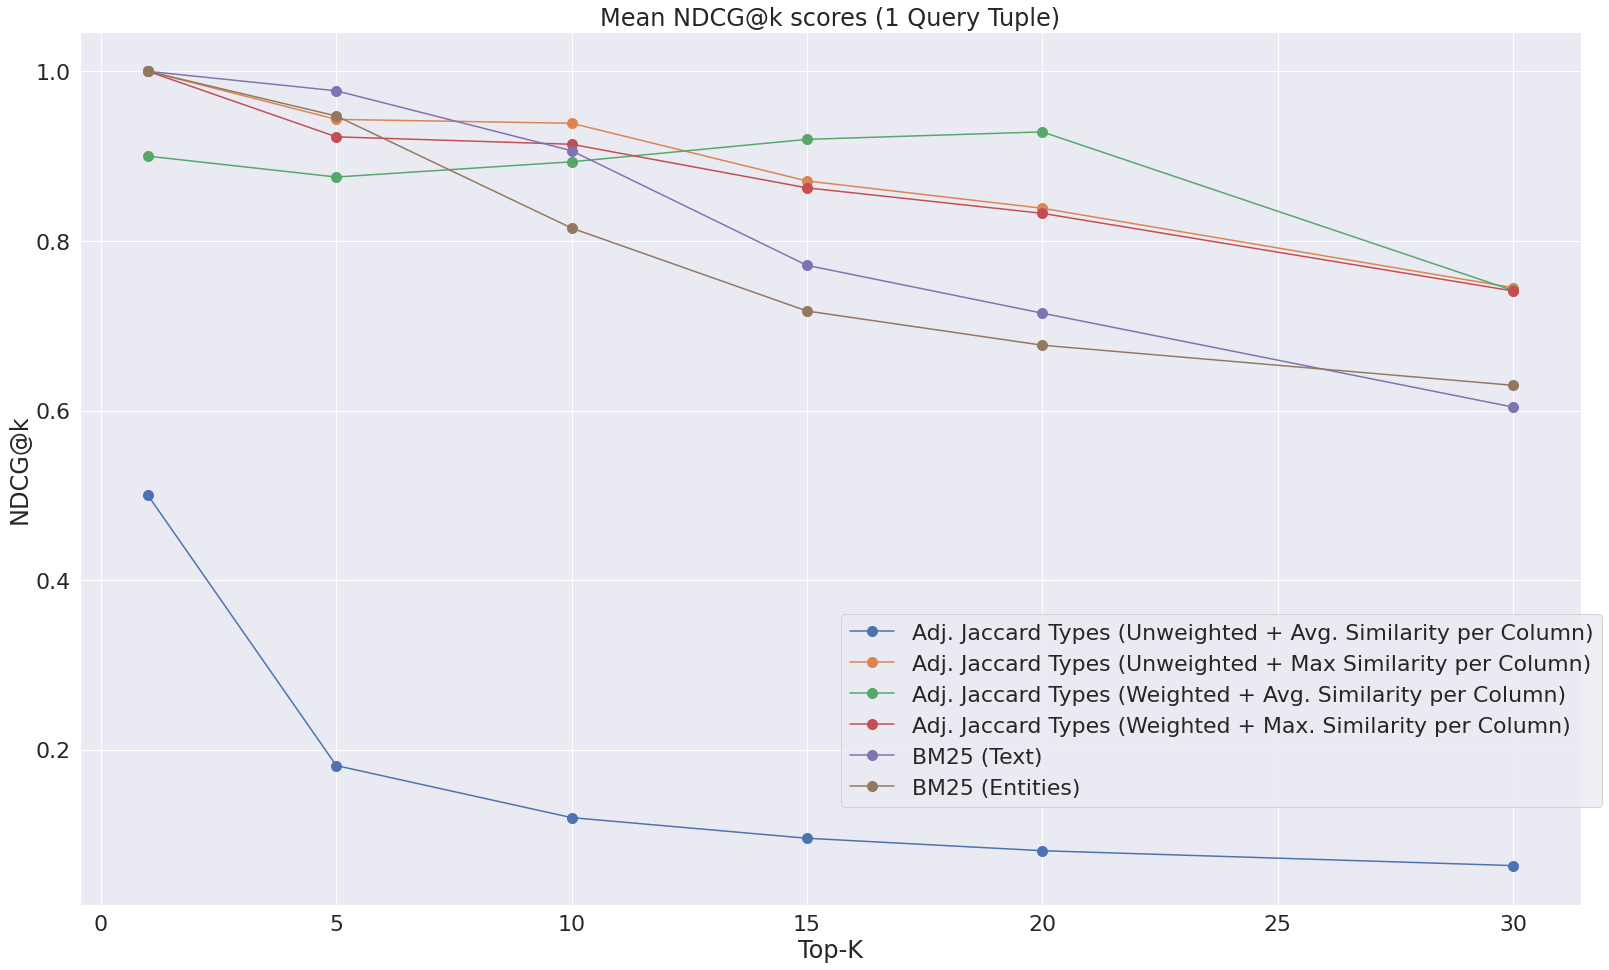

In [32]:
num_query_tuples=1

bm25_entities = [dfs_dict[tuples_per_query_list[0]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]
bm25_text = [dfs_dict[tuples_per_query_list[0]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

fig = plt.figure()
ax = plt.subplot(111)

plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_avg_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Unweighted + Avg. Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Unweighted + Max Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_avg_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Weighted + Avg. Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_max_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Weighted + Max. Similarity per Column)')

plt.plot(top_k_vals, bm25_text,
    marker='o', markersize=10, label='BM25 (Text)')
plt.plot(top_k_vals, bm25_entities,
    marker='o', markersize=10, label='BM25 (Entities)')

plt.legend();ax.legend(bbox_to_anchor=(0.5, 0.1))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (1 Query Tuple)');plt.tight_layout()
plt.savefig('figures/wikipages_test_dataset/evaluation_across_different_methods_1_query_tuple.svg')

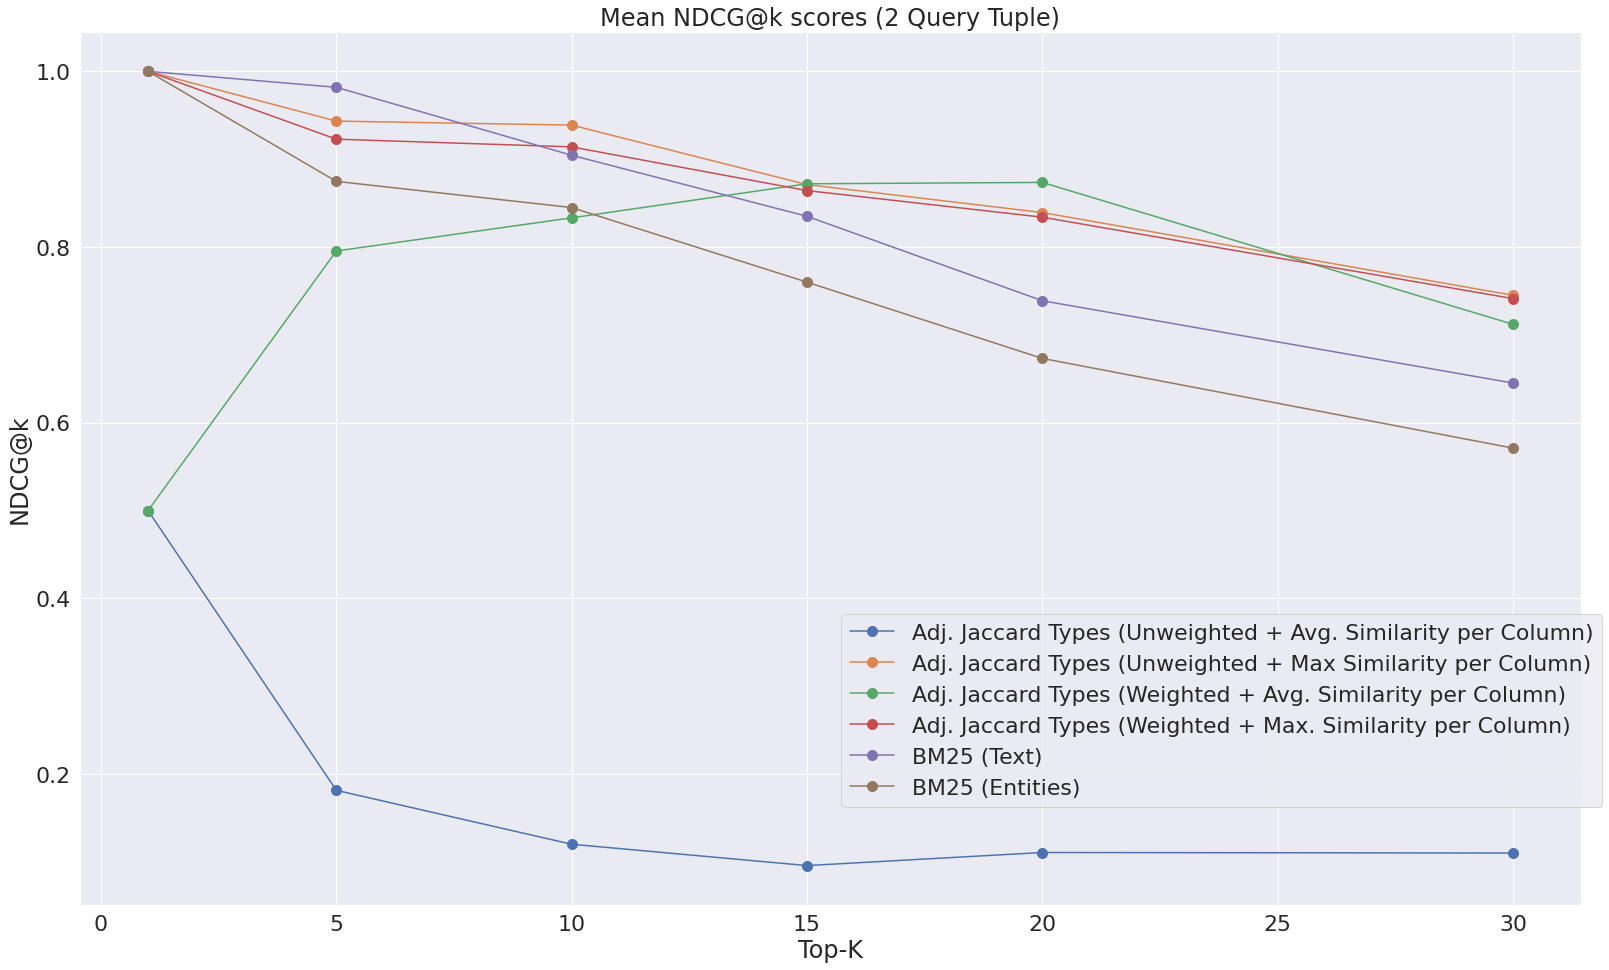

In [33]:
num_query_tuples=2

bm25_entities = [dfs_dict[tuples_per_query_list[1]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]
bm25_text = [dfs_dict[tuples_per_query_list[1]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

fig = plt.figure()
ax = plt.subplot(111)

plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_avg_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Unweighted + Avg. Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Unweighted + Max Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_avg_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Weighted + Avg. Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_max_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Weighted + Max. Similarity per Column)')

plt.plot(top_k_vals, bm25_text,
    marker='o', markersize=10, label='BM25 (Text)')
plt.plot(top_k_vals, bm25_entities,
    marker='o', markersize=10, label='BM25 (Entities)')

plt.legend();ax.legend(bbox_to_anchor=(0.5, 0.1))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (2 Query Tuple)');plt.tight_layout()
plt.savefig('figures/wikipages_test_dataset/evaluation_across_different_methods_2_query_tuple.svg')

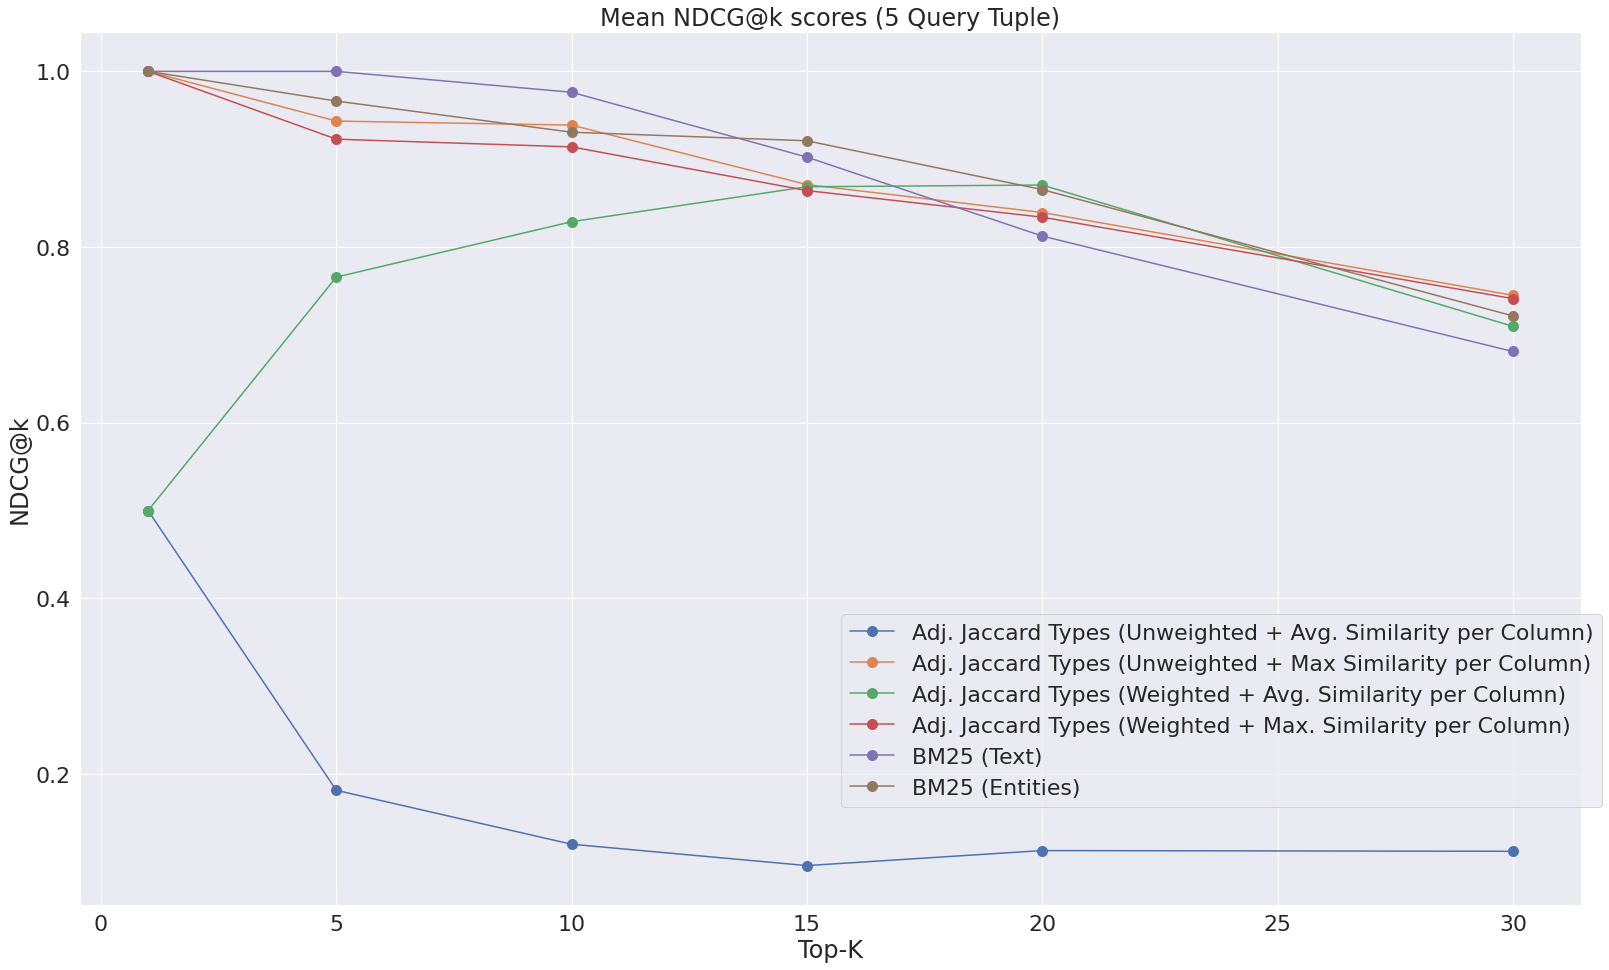

In [34]:
num_query_tuples=5

bm25_entities = [dfs_dict[tuples_per_query_list[2]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]
bm25_text = [dfs_dict[tuples_per_query_list[2]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

fig = plt.figure()
ax = plt.subplot(111)

plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_avg_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Unweighted + Avg. Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Unweighted + Max Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_avg_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Weighted + Avg. Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_max_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Weighted + Max. Similarity per Column)')

plt.plot(top_k_vals, bm25_text,
    marker='o', markersize=10, label='BM25 (Text)')
plt.plot(top_k_vals, bm25_entities,
    marker='o', markersize=10, label='BM25 (Entities)')

plt.legend();ax.legend(bbox_to_anchor=(0.5, 0.1))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (5 Query Tuple)');plt.tight_layout()
plt.savefig('figures/wikipages_test_dataset/evaluation_across_different_methods_5_query_tuple.svg')

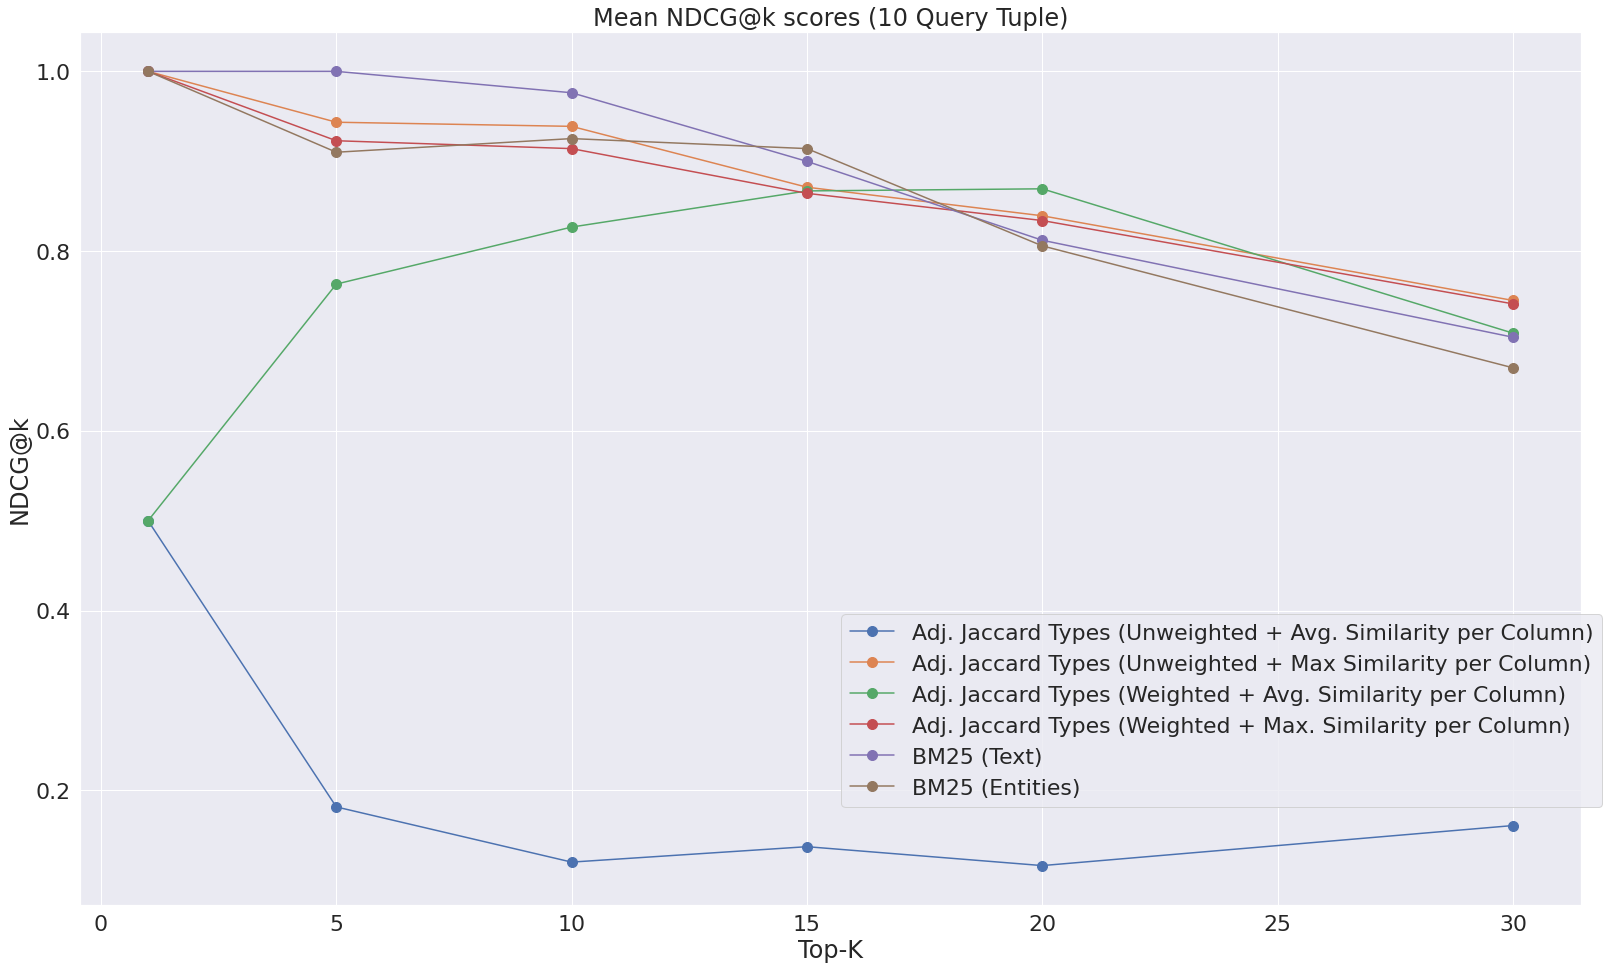

In [35]:
num_query_tuples=10

bm25_entities = [dfs_dict[tuples_per_query_list[3]]['entities']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]
bm25_text = [dfs_dict[tuples_per_query_list[3]]['text']['content_categories']['ndcg@'+str(k)].mean() for k in top_k_vals]

fig = plt.figure()
ax = plt.subplot(111)

plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_avg_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Unweighted + Avg. Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Unweighted + Max Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_avg_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Weighted + Avg. Similarity per Column)')
plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_weighted_max_sim[num_query_tuples],
    marker='o', markersize=10, label='Adj. Jaccard Types (Weighted + Max. Similarity per Column)')

plt.plot(top_k_vals, bm25_text,
    marker='o', markersize=10, label='BM25 (Text)')
plt.plot(top_k_vals, bm25_entities,
    marker='o', markersize=10, label='BM25 (Entities)')

plt.legend();ax.legend(bbox_to_anchor=(0.5, 0.1))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores (10 Query Tuple)');plt.tight_layout()
plt.savefig('figures/wikipages_test_dataset/evaluation_across_different_methods_10_query_tuple.svg')

# Hungarian Algorithm (Same Alignment Across Query Tuples vs. Independent Alignment)

In [53]:
adj_jaccard_unweighted_max_sim_per_col_same_alignment_scores='eval_over_search_output/wikipages_test_dataset/filtered_queries/adjusted_jaccard/unweighted/max_similarity_per_col_same_alignment/'

# Get the dataframes of the evaluation scores at different # of tuples per query 
adj_jaccard_unweighted_max_sim_same_alignment_df = get_query_df_dict(
    query_df_base_dir=query_df_base_dir,
    score_paths_base_dir=adj_jaccard_unweighted_max_sim_per_col_same_alignment_scores,
    min_tuple_width=min_tuple_width,
    mode = 'jaccard_categories',
    tuples_per_query_list=tuples_per_query_list
)

# Get dictionaries keyed by the tuples per query mapping to a list of the NDCG scores at the specified top-k
adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim_same_alignment, _ = get_ndcg_scores_at_k_stats(adj_jaccard_unweighted_max_sim_same_alignment_df, top_k_vals, tuples_per_query_list)

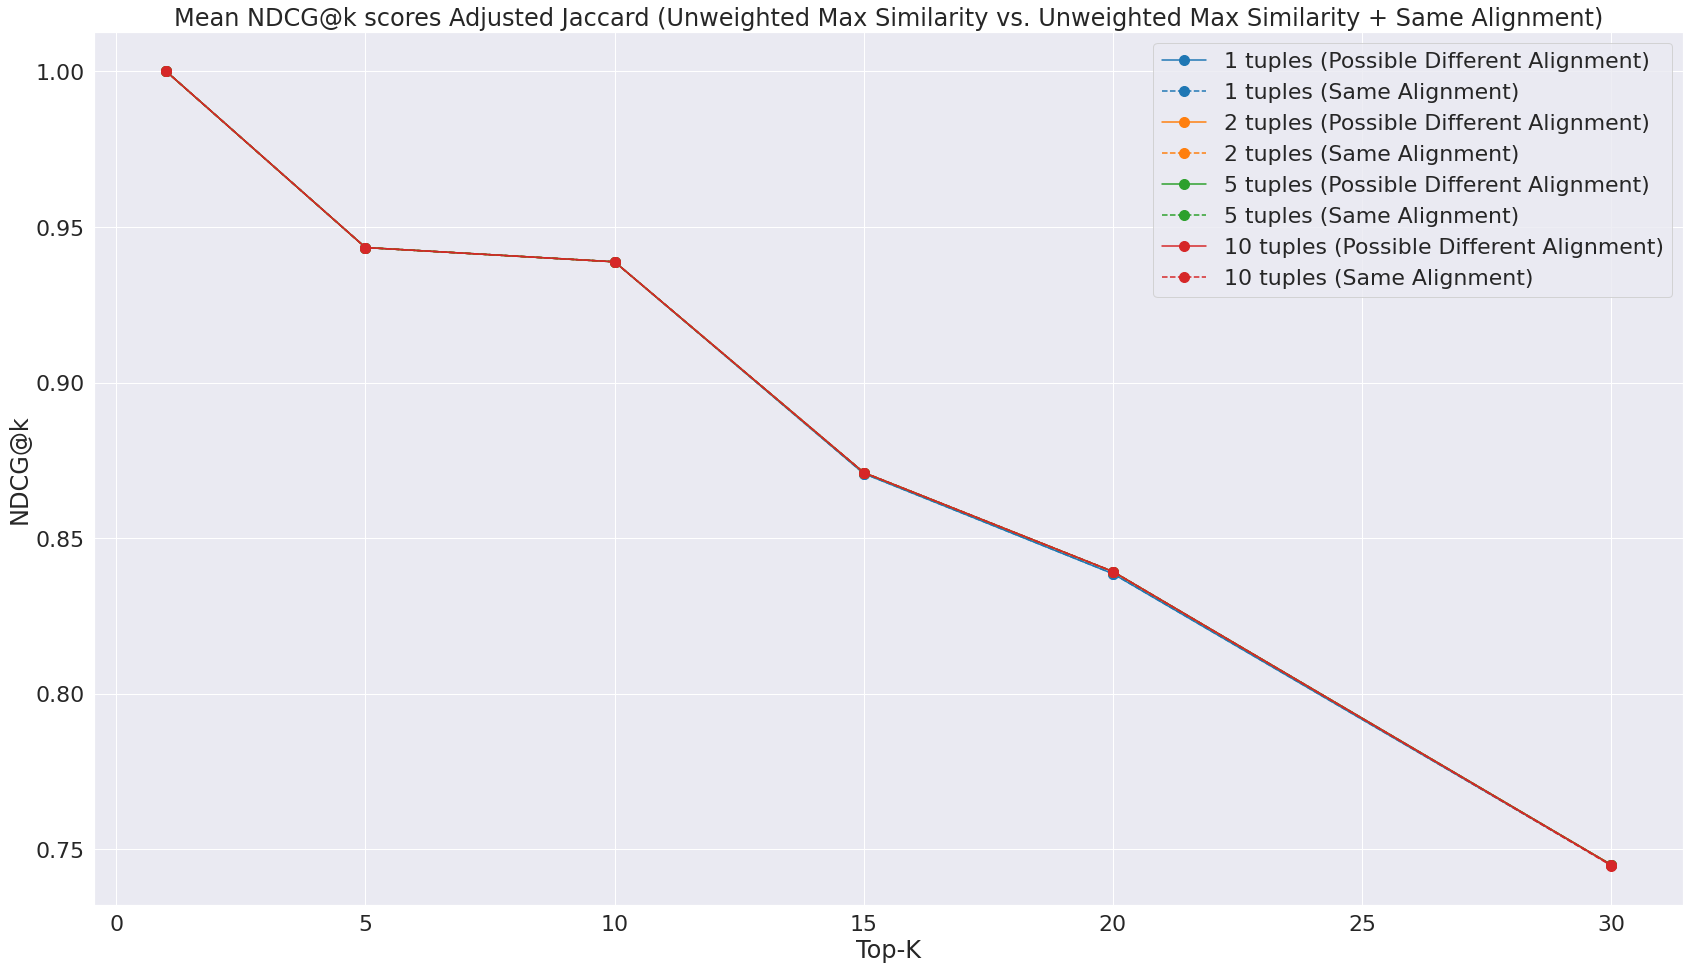

In [56]:
colors=['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
fig = plt.figure()
ax = plt.subplot(111)
for i in range(len(tuples_per_query_list)):
    plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Possible Different Alignment)')

    plt.plot(top_k_vals, adj_jaccard_mean_ndcg_scores_at_k_unweighted_max_sim_same_alignment[tuples_per_query_list[i]],
        marker='o', markersize=10, color=colors[i], label=str(tuples_per_query_list[i]) + ' tuples (Same Alignment)', linestyle='--')

plt.legend();ax.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("Top-K");plt.ylabel('NDCG@k');plt.title('Mean NDCG@k scores Adjusted Jaccard (Unweighted Max Similarity vs. Unweighted Max Similarity + Same Alignment)');plt.tight_layout()

# Exploration of output

In [40]:
queries_df = pd.read_pickle('../../data/queries/wikipages/query_dataframes/wikipages_test_dataset/filtered_queries/minTupleWidth_2_tuplesPerQuery_2.pickle')
queries_df

,wikipage,wikipage_id,num_tables,tables,num_entities,tuple_width,num_tuples,selected_table,selected_row_ids,categories_relevant_wikipages,categories_relevant_tables,navigation_links_relevant_wikipages,navigation_links_relevant_tables,categories_expansion_ratio,navigation_links_expansion_ratio,avg_query_containment
1119,https://en.wikipedia.org/wiki/List_of_Norwegia...,1119,1,[table-0007-748.json],[40],3.0,2.0,table-0007-748.json,"[0, 2]",55.0,100.0,NaN,NaN,100.0,NaN,0.024691


In [41]:
df = pd.read_pickle('../../data/tables/wikipages/wikipages_expanded_dataset/wikipages_df.pickle')

# Construct a dictionary that maps each table name to its respective wikipage_id
table_to_wikipage_id_dict = {}
for _, row in tqdm(df.iterrows(), total=len(df.index)):
    for table in row['tables']:
        table_to_wikipage_id_dict[table] = row['wikipage_id']

relevance_scores_dir = '../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_testing_dataset/jaccard_categories_new/'
wikipage_to_categories_path = '../../data/queries/wikipages/groundtruth_generation/wikipage_relevance_scores/wikipages_expanded_dataset/wikipage_to_categories.json'
with open(wikipage_to_categories_path) as fp:
    wikipage_to_categories_dict = json.load(fp)


queries_path='../../data/queries/wikipages/queries/wikipages_test_dataset/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/'
scores_dir = '../../data/search/wikipages_test/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/adjusted_jaccard/'
bm_25_scores_dir = '../../Web-Table-Retrieval-Benchmark/data/wikipages_testing/ranking/filtered_queries/minTupleWidth_2_tuplesPerQuery_2/'

100%|██████████| 149526/149526 [00:05<00:00, 29181.53it/s]


In [42]:
get_query_summary(
    wikipage_id=1119, df=df, relevance_scores_dir=relevance_scores_dir, scores_dir=scores_dir, bm_25_scores_dir=bm_25_scores_dir,
    queries_path=queries_path, wikipage_to_attributes_dict=wikipage_to_categories_dict,
    table_to_wikipage_id_dict=table_to_wikipage_id_dict, k=10
)

Query Constructed from Wikipedia Page: https://en.wikipedia.org/wiki/List_of_Norwegian_consorts

Query Tuples:
['http://dbpedia.org/resource/Dorothea_of_Brandenburg', 'http://dbpedia.org/resource/John,_Margrave_of_Brandenburg-Kulmbach', 'http://dbpedia.org/resource/Christian_I_of_Denmark']
['http://dbpedia.org/resource/Christina_of_Saxony', 'http://dbpedia.org/resource/Ernest,_Elector_of_Saxony', 'http://dbpedia.org/resource/John,_King_of_Denmark']

Wikipedia Categories of query Wikipage:
['Lists Of Norwegian People', 'Lists Of Queens', 'Lists Of Royal Consorts', 'Lists Of Women', 'Norwegian Royal Consorts']

Relevant Wikipages (Ground Truth):
{'List_of_Norwegian_consorts': 1.0, 'List_of_English_consorts': 0.9, 'List_of_heirs_to_the_English_throne': 0.8, 'List_of_Austrian_consorts': 0.9, 'Dukedoms_of_the_British_Isles_by_reign': 0.5, 'List_of_Castilian_consorts': 0.9, 'Imperial_vicar': 0.5, 'Princess_Royal': 0.8, 'List_of_Scottish_consorts': 0.9, 'List_of_heirs_to_the_Prussian_throne':